# Notebook 4: Comparative Analysis of Fine-tuning Setups

**Goal:**
1.  Load and compare the evaluation results from two specific fine-tuning setups:
    *   `resnet_mid_aug` (ResNet18, 'mid' unfreeze, with training data augmentation)
    *   `resnet_mid_noaug` (ResNet18, 'mid' unfreeze, without training data augmentation)
2.  Visualize the differences in their performance metrics.
3.  Perform a qualitative analysis by examining specific images where the two models' predictions differ.
4.  Discuss the impact of data augmentation on this particular model and unfreezing strategy.
5.  (Optional) Briefly touch upon the project repository structure and README content.

**Prerequisites:**
*   Notebook `03_Evaluation.ipynb` must have been run for both `resnet_mid_aug` and `resnet_mid_noaug` setups.
*   The following files must exist from those runs:
    *   `eval_metrics_resnet_mid_aug.csv` (Classification report)
    *   `predictions_resnet_mid_aug.csv`
    *   `eval_metrics_resnet_mid_noaug.csv`
    *   `predictions_resnet_mid_noaug.csv`
    *   (Optional) `best_params_resnet_mid_aug.json` and `best_params_resnet_mid_noaug.json` (HPO params still in JSON).

In [1]:
import torch
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# No need for ConfusionMatrixDisplay here unless you want to re-plot CMs

# Import utility functions (if needed, e.g., for loading datasets for visualization)
import utils

# --- Define the two Setup IDs to compare ---
SETUP_A_ID = 'resnet_mid_aug'
SETUP_B_ID = 'resnet_mid_noaug'

print(f"Comparing Setup A: {SETUP_A_ID}")
print(f"Comparing Setup B: {SETUP_B_ID}")

# --- Check for necessary files ---
required_files_A = [f"eval_metrics_{SETUP_A_ID}.csv", f"predictions_{SETUP_A_ID}.csv"]
required_files_B = [f"eval_metrics_{SETUP_B_ID}.csv", f"predictions_{SETUP_B_ID}.csv"]

files_missing = False
for f_path in required_files_A + required_files_B:
    if not os.path.exists(f_path):
        print(f"Error: Required file not found: {f_path}")
        files_missing = True

if files_missing:
    print("\nPlease ensure Notebook 03 has been run for both setups and output files are present.")
else:
    print("All required files found.")

# --- Device (primarily for potential model loading if needed, less critical here) ---
if torch.backends.mps.is_available() and torch.backends.mps.is_built():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(f"Using device: {device}")

# Get class names (assuming OxfordIIITPet structure, needed for labels)
temp_test_dataset = utils.get_datasets(task='test', augment_train=False)
if hasattr(temp_test_dataset, '_breeds'):
    class_names = temp_test_dataset._breeds
elif hasattr(temp_test_dataset, 'classes'):
    class_names = temp_test_dataset.classes
else:
    class_names = [str(i) for i in range(utils.NUM_CLASSES)]

Comparing Setup A: resnet_mid_aug
Comparing Setup B: resnet_mid_noaug
All required files found.
Using device: mps


In [2]:
if not files_missing:
    comparison_data = []
    setup_ids_to_compare = [SETUP_A_ID, SETUP_B_ID]

    for setup_id in setup_ids_to_compare:
        metrics_csv_file = f"eval_metrics_{setup_id}.csv"
        params_json_file = f"best_params_{setup_id}.json" # HPO params still in JSON

        # Load metrics CSV
        metrics_df = pd.read_csv(metrics_csv_file, index_col=0) # First column is the class name or avg type

        # Load HPO params if file exists
        if os.path.exists(params_json_file):
            params = utils.load_json(params_json_file)
        else:
            params = {'lr_head': 'N/A', 'lr_backbone': 'N/A', 'weight_decay': 'N/A'}
            print(f"Warning: best_params file not found for {setup_id}. HPO params will be N/A.")

        # Extract overall accuracy (assuming it was saved as a separate value or find 'accuracy' row in report)
        # The new save format for eval_metrics.csv stores 'accuracy' as a row.
        overall_accuracy = metrics_df.loc['accuracy', 'precision'] if 'accuracy' in metrics_df.index else metrics_df.loc['weighted avg', 'precision'] # Fallback to weighted avg precision if 'accuracy' row name isn't exact
        # Note: Your eval_metrics CSV now has 'accuracy' as a row where 'precision' column holds the value.
        # If you want to extract it from a separate value, adjust accordingly.
        # Let's assume the 'accuracy' row exists and its value is in the first column (e.g., 'precision' after T)
        # Or, if it was stored distinctly from the report, you'd load that.
        # For now, we'll use the 'accuracy' row if it exists in the saved CSV report_df.

        # Extract model, unfreeze, augment from setup_id
        parts = setup_id.split('_')
        model_name_from_id = parts[0]
        unfreeze_from_id = parts[1]
        aug_from_id = (parts[2] == 'aug') if len(parts) > 2 else False

        comparison_data.append({
            'Setup ID': setup_id,
            'Model': model_name_from_id,
            'Unfreeze': unfreeze_from_id,
            'Augment': aug_from_id,
            'LR Head': params.get('lr_head', 'N/A'),
            'LR Backbone': params.get('lr_backbone', 'N/A'),
            'Weight Decay': params.get('weight_decay', 'N/A'),
            'Accuracy': overall_accuracy, # Already in % from your save format
            'Macro Avg F1': metrics_df.loc['macro avg', 'f1-score'],
            'Weighted Avg F1': metrics_df.loc['weighted avg', 'f1-score'],
        })

    results_df = pd.DataFrame(comparison_data)
    if not results_df.empty:
        results_df = results_df.sort_values(by='Accuracy', ascending=False)

    print("\n--- Combined Results Table for Comparison ---")
    display(results_df)
else:
    print("Cannot proceed with metric comparison due to missing files.")
    results_df = pd.DataFrame()


--- Combined Results Table for Comparison ---


,Setup ID,Model,Unfreeze,Augment,LR Head,LR Backbone,Weight Decay,Accuracy,Macro Avg F1,Weighted Avg F1
1,resnet_mid_noaug,resnet,mid,False,0.005,0.0001,0,87.61,86.75,86.79
0,resnet_mid_aug,resnet,mid,True,0.005,0.0001,0,85.36,82.87,82.96


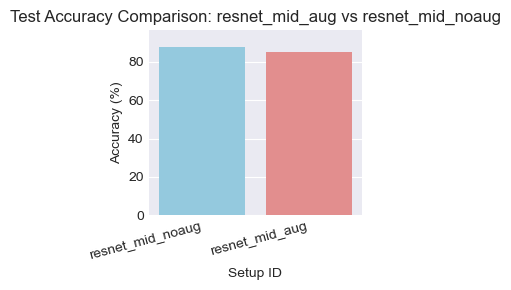

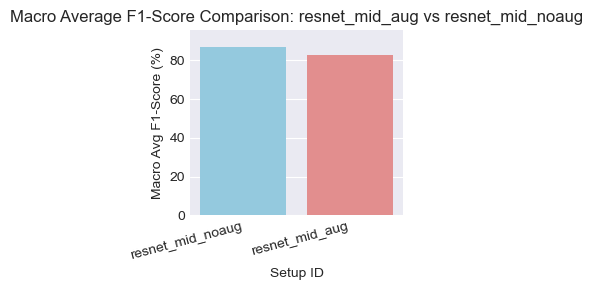

In [7]:
from matplotlib import axes


if not results_df.empty:
    plt.style.use('seaborn-v0_8-darkgrid')
    # Bar Chart: Accuracy Comparison
    plt.figure(figsize=(3,3))
    sns.barplot(x='Setup ID', y='Accuracy', data=results_df, hue='Setup ID', palette=['skyblue', 'lightcoral'])
    plt.title(f'Test Accuracy Comparison: {SETUP_A_ID} vs {SETUP_B_ID}')
    plt.ylabel('Accuracy (%)')
    plt.xlabel('Setup ID')
    plt.ylim(0, max(results_df['Accuracy'].max() * 1.1 if not results_df.empty else 100, 50))
    plt.xticks(rotation=15, ha='right')
    plt.tight_layout()
    plt.show()

    # Bar Chart: Macro F1 Comparison
    plt.figure(figsize=(3,3))
    sns.barplot(x='Setup ID', y='Macro Avg F1', data=results_df, hue='Setup ID', palette=['skyblue', 'lightcoral'])
    plt.title(f'Macro Average F1-Score Comparison: {SETUP_A_ID} vs {SETUP_B_ID}')
    plt.ylabel('Macro Avg F1-Score (%)') # Assuming F1 is also in %
    plt.xlabel('Setup ID')
    plt.ylim(0, max(results_df['Macro Avg F1'].max() * 1.1 if not results_df.empty else 100, 50))
    plt.xticks(rotation=15, ha='right')
    plt.tight_layout()
    plt.show()
else:
    print("No results to visualize.")


--- Qualitative Prediction Comparison (resnet_mid_aug vs resnet_mid_noaug) ---
Cases where resnet_mid_aug Correct, resnet_mid_noaug Wrong: 142


,image_id,true_label_name,predicted_label_name_resnet_mid_aug,predicted_label_name_resnet_mid_noaug
4,4,Abyssinian,Abyssinian,Bengal
17,17,Abyssinian,Abyssinian,Bengal
39,39,Abyssinian,Abyssinian,Beagle
46,46,Abyssinian,Abyssinian,Bengal
53,53,Abyssinian,Abyssinian,Bengal



Cases where resnet_mid_noaug Correct, resnet_mid_aug Wrong: 273


,image_id,true_label_name,predicted_label_name_resnet_mid_aug,predicted_label_name_resnet_mid_noaug
1,1,Abyssinian,Sphynx,Abyssinian
5,5,Abyssinian,Yorkshire Terrier,Abyssinian
6,6,Abyssinian,Miniature Pinscher,Abyssinian
35,35,Abyssinian,Boxer,Abyssinian
36,36,Abyssinian,Russian Blue,Abyssinian



Cases where Both Wrong but Differently: 100


,image_id,true_label_name,predicted_label_name_resnet_mid_aug,predicted_label_name_resnet_mid_noaug
3,3,Abyssinian,American Pit Bull Terrier,Miniature Pinscher
14,14,Abyssinian,Keeshond,Persian
16,16,Abyssinian,Egyptian Mau,Bengal
20,20,Abyssinian,Chihuahua,Pug
188,188,American Bulldog,Shiba Inu,Beagle



Visualizing: resnet_mid_aug_Correct_resnet_mid_noaug_Wrong


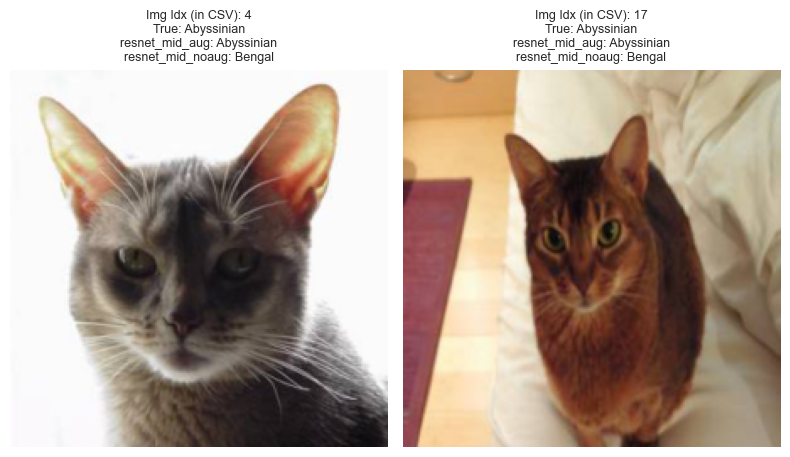


Visualizing: resnet_mid_noaug_Correct_resnet_mid_aug_Wrong


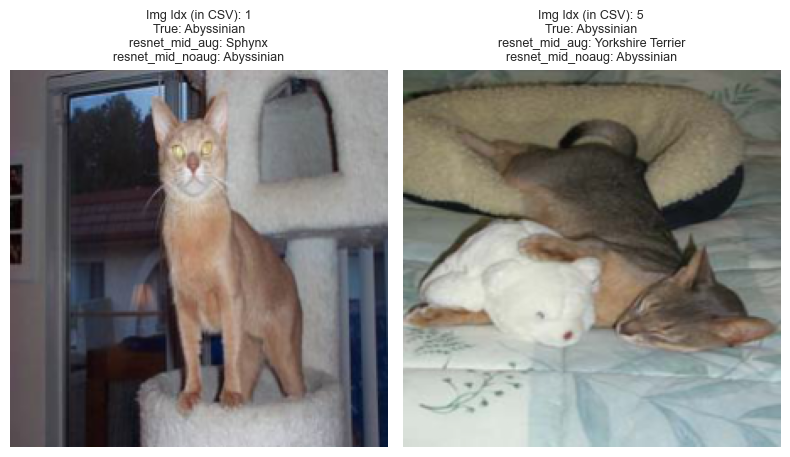


Visualizing: Both_Wrong_Different


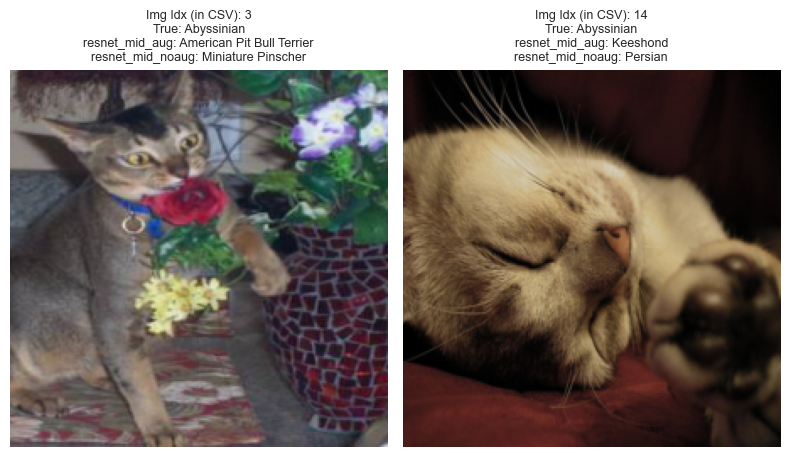

In [8]:
if not files_missing:
    print(f"\n--- Qualitative Prediction Comparison ({SETUP_A_ID} vs {SETUP_B_ID}) ---")
    # Load predictions from CSV files
    preds_A_df = pd.read_csv(f"predictions_{SETUP_A_ID}.csv")
    preds_B_df = pd.read_csv(f"predictions_{SETUP_B_ID}.csv")

    # Merge predictions based on image_id (assuming 'image_id' column exists in CSVs)
    comparison_df = pd.merge(preds_A_df, preds_B_df, on='image_id', suffixes=(f'_{SETUP_A_ID}', f'_{SETUP_B_ID}'))

    # Standardize true label column name
    # Your CSV already has 'true_label_name' and 'predicted_label_name'
    # We need to ensure we are comparing against the correct true label after merge
    comparison_df = comparison_df.rename(columns={f'true_label_name_{SETUP_A_ID}': 'true_label_name'})
    # Drop redundant true label columns from the second DataFrame
    if f'true_label_name_{SETUP_B_ID}' in comparison_df:
        comparison_df = comparison_df.drop(columns=[f'true_label_name_{SETUP_B_ID}'])
    if f'true_label_idx_{SETUP_A_ID}' in comparison_df:
        comparison_df = comparison_df.drop(columns=[f'true_label_idx_{SETUP_A_ID}'])
    if f'true_label_idx_{SETUP_B_ID}' in comparison_df:
        comparison_df = comparison_df.drop(columns=[f'true_label_idx_{SETUP_B_ID}'])


    # Find examples where Model A is correct and Model B is wrong
    a_correct_b_wrong = comparison_df[
        (comparison_df[f'predicted_label_name_{SETUP_A_ID}'] == comparison_df['true_label_name']) &
        (comparison_df[f'predicted_label_name_{SETUP_B_ID}'] != comparison_df['true_label_name'])
    ]

    # Find examples where Model B is correct and Model A is wrong
    b_correct_a_wrong = comparison_df[
        (comparison_df[f'predicted_label_name_{SETUP_B_ID}'] == comparison_df['true_label_name']) &
        (comparison_df[f'predicted_label_name_{SETUP_A_ID}'] != comparison_df['true_label_name'])
    ]
    
    # Find examples where both are wrong but different from each other
    both_wrong_different = comparison_df[
        (comparison_df[f'predicted_label_name_{SETUP_A_ID}'] != comparison_df['true_label_name']) &
        (comparison_df[f'predicted_label_name_{SETUP_B_ID}'] != comparison_df['true_label_name']) &
        (comparison_df[f'predicted_label_name_{SETUP_A_ID}'] != comparison_df[f'predicted_label_name_{SETUP_B_ID}'])
    ]

    print(f"Cases where {SETUP_A_ID} Correct, {SETUP_B_ID} Wrong: {len(a_correct_b_wrong)}")
    display(a_correct_b_wrong[['image_id', 'true_label_name', f'predicted_label_name_{SETUP_A_ID}', f'predicted_label_name_{SETUP_B_ID}']].head())

    print(f"\nCases where {SETUP_B_ID} Correct, {SETUP_A_ID} Wrong: {len(b_correct_a_wrong)}")
    display(b_correct_a_wrong[['image_id', 'true_label_name', f'predicted_label_name_{SETUP_A_ID}', f'predicted_label_name_{SETUP_B_ID}']].head())
    
    print(f"\nCases where Both Wrong but Differently: {len(both_wrong_different)}")
    display(both_wrong_different[['image_id', 'true_label_name', f'predicted_label_name_{SETUP_A_ID}', f'predicted_label_name_{SETUP_B_ID}']].head())


    # --- Visualize a few example images ---
    vis_test_dataset = utils.get_datasets(task='test', augment_train=False)

    def show_prediction_comparison_image(image_idx_in_dataset, df_row, setup_a_id, setup_b_id):
        if image_idx_in_dataset >= len(vis_test_dataset):
            print(f"Image index {image_idx_in_dataset} out of bounds for visualization dataset.")
            return
        img_tensor, _ = vis_test_dataset[image_idx_in_dataset]
        mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
        img_unnorm = img_tensor * std + mean
        img_unnorm = torch.clamp(img_unnorm, 0, 1)
        plt.imshow(img_unnorm.permute(1, 2, 0))
        title = (f"Img Idx (in CSV): {df_row['image_id']}\nTrue: {df_row['true_label_name']}\n" # Image_id from CSV
                 f"{setup_a_id}: {df_row[f'predicted_label_name_{setup_a_id}']}\n"
                 f"{setup_b_id}: {df_row[f'predicted_label_name_{setup_b_id}']}"
                )
        plt.title(title, fontsize=9)
        plt.axis('off')

    # Select example cases to visualize
    cases_to_viz = {
        f"{SETUP_A_ID}_Correct_{SETUP_B_ID}_Wrong": a_correct_b_wrong,
        f"{SETUP_B_ID}_Correct_{SETUP_A_ID}_Wrong": b_correct_a_wrong,
        "Both_Wrong_Different": both_wrong_different
    }
    num_examples_per_case = 2

    for case_name, case_df in cases_to_viz.items():
        if not case_df.empty:
            print(f"\nVisualizing: {case_name}")
            current_num_examples = min(num_examples_per_case, len(case_df))
            if current_num_examples == 0: continue

            plt.figure(figsize=(current_num_examples * 4, 5))
            for i in range(current_num_examples):
                row_to_plot = case_df.iloc[i]
                # 'image_id' in your CSV is the sequential index from 0 to N-1
                image_dataset_index = row_to_plot['image_id']
                plt.subplot(1, current_num_examples, i + 1)
                show_prediction_comparison_image(image_dataset_index, row_to_plot, SETUP_A_ID, SETUP_B_ID)
            plt.tight_layout()
            plt.show()
        else:
            print(f"No examples found for case: {case_name}")
else:
    print("Skipping qualitative analysis due to missing prediction or metric files.")

## Synthesizing Findings and Project Structure

**Discussion of Comparative Results (`resnet_mid_aug` vs. `resnet_mid_noaug`):**
*   Looking at the `results_df` and visualizations:
    *   How did the test accuracy compare between the augmented and non-augmented setups?
    *   How did the Macro Average F1-Score compare?
    *   What does this suggest about the impact of data augmentation for the ResNet model with a 'mid' level unfreeze strategy on this dataset?
*   From the qualitative analysis (images where predictions differed):
    *   Were there any particular classes where augmentation seemed to help or hurt?
    *   Did the types of errors made by the two models differ in noticeable ways?
*   What are the potential reasons for the observed differences (or lack thereof)? Consider dataset size, complexity of the task, and the nature of the augmentations used.

**(Optional) Broader Project Discussion & README Outline:**
*   If all 12 experiments were completed by the class:
    *   Which overall setup (Model x Unfreeze x Augmentation) performed best?
    *   What general trends were observed across all experiments?
*   **README.md for the Project Repository:**
    *   **Goal:** Comparison of fine-tuning strategies (ResNet vs. MobileNet) on Oxford-IIIT Pet dataset, investigating effects of unfreezing depth and data augmentation.
    *   **Dataset:** Oxford-IIIT Pet.
    *   **Methodology:**
        *   Briefly describe the 12 experimental setups.
        *   Outline the 3-notebook workflow (`01_hpo`, `02_train`, `03_eval`) and the purpose of `04_comparative_analysis`.
        *   Mention the HPO process (hyperparameters tuned, short epochs) and final training (longer epochs, early stopping).
    *   **Key Files & Structure:** Point to `utils.py`, the notebooks, and the `results/` directory structure (mentioning CSVs for metrics/predictions).
    *   **Results Summary:**
        *   Link to or embed the main `all_setups_results_summary.csv` (if generated from all 12 runs).
        *   Include key comparative visualizations.
        *   A concise written summary of the main findings and conclusions.
    *   **How to Reproduce:** Steps to run the HPO, training, and evaluation for a single setup.
    *   **Dependencies:** List of major Python libraries used.